# Frozen Lake

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import numpy as np

from qlearn import DiscreteQTable, QTable, plot_rewards, basic_training, run_episode

from typing import Any, Iterable, Sequence, Tuple, Union
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def basic_training(env: gym.Env, 
                   qtable: QTable, 
                   episodes: int,
                   alpha=0.1, 
                   gamma=0.6, 
                   epsilon=0.1, 
                   epsilon_decay=0, 
                   epsilon_min=0.01, 
                   verbose: bool=False
                   ) -> Iterable[float]:
    
    rewards = []
    epsilon_c = epsilon

    for episode in range(episodes):

        state = env.reset()
        episode_reward = 0
        random_count = 0
        done = False

        # while the agent is alive or 
        # has not reached the target
        while not done:
            
            if epsilon_c > np.random.random():
                # exploration: choose random acton
                # in case if paramenter epsilon_c will be larger 
                # then random number from 0 to 1
                action = env.action_space.sample()
                random_count += 1
            else:
                # choose the action with the highest value in the current state
                action = qtable.policy(state)
            
            # perform action and collect info
            new_state, r, done, _ = env.step(action)

            # Reward engineering
            if done and r == 0:
                # it dies
                r = -10
            elif done and r == 1:
                # it reaches a goal
                r = 100
            else:
                # remove 1 just because it performs step
                r = -1

            # update expected reward (Q function)
            Q = (1 - alpha) * qtable.expected(state, action) + alpha * (r + gamma * qtable.expected(new_state))
            qtable.update(state, action, Q)

            state = new_state
            episode_reward += r

            # if agent dies or reaches a goal
            if done:
                if verbose:
                    print(f'Episode {episode}/{episodes}: reward {episode_reward}, random actions {random_count}, epsilon {epsilon_c}')
                
                # decrease probability of choosing random action
                epsilon_c = epsilon_min + (epsilon - epsilon_min) * np.exp(-epsilon_decay * episode)

                # decay learning rate
                # alpha = alpha * (1 - episode / episodes)

                rewards.append(episode_reward)

    env.close()
    return qtable, rewards

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False)
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
qtable = DiscreteQTable(env)
qtable.__repr__()

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

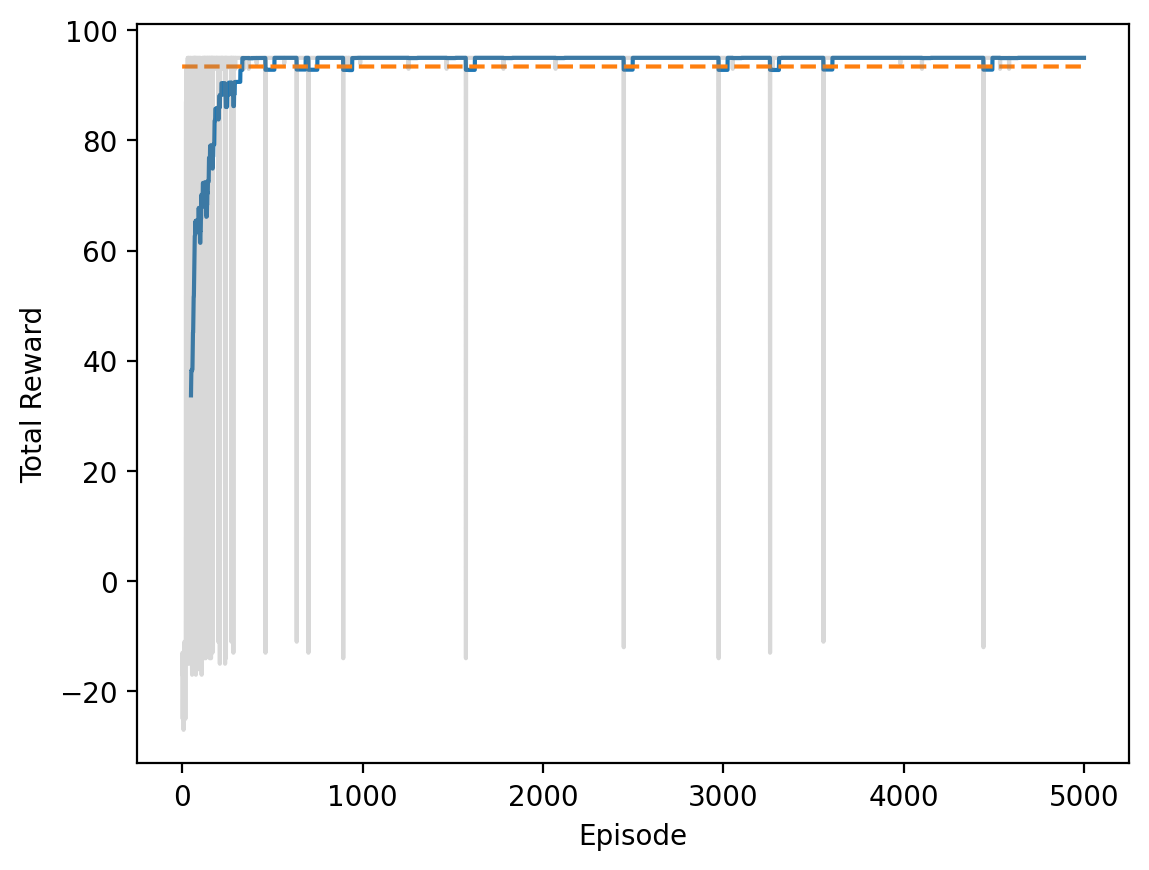

In [5]:
qtable, rewards = basic_training(
    env=env,
    qtable=qtable, 
    episodes=5000, 
    alpha=0.90, 
    gamma=0.05, 
    epsilon=0.40,
    epsilon_min=1e-3,
    epsilon_decay=0.01, 
    verbose=False
)

plot_rewards(rewards);

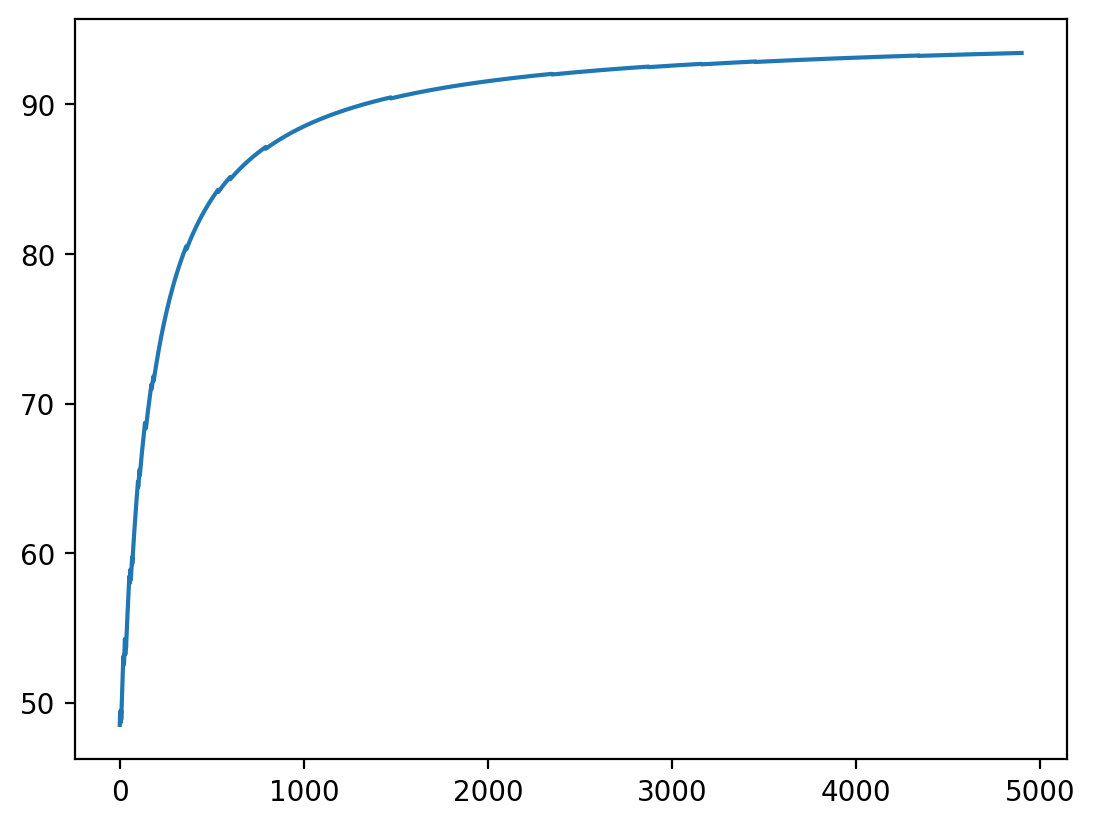

In [6]:
burn_period = 100
plt.plot(np.cumsum(rewards)[burn_period:] / np.arange(len(rewards))[burn_period:]);

In [7]:
# SFFF
# FHFH
# FFFH
# HFFG

In [8]:
qtable.__repr__()

array([[ -1.05263   ,  -1.0526    ,  -1.0526    ,  -1.05263   ],
       [ -1.05262829,  -9.9999    ,  -1.052     ,  -1.05262129],
       [ -1.05258857,  -1.04      ,  -1.05246045,  -1.05216626],
       [ -1.0525643 ,  -9.9       ,  -1.05256411,  -1.05244064],
       [ -1.0526    ,  -1.052     , -10.        ,  -1.05263   ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.999     ,  -0.8       ,  -9.999     ,  -1.05247509],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -1.052     ,  -9.9999999 ,  -1.04      ,  -1.0526    ],
       [ -1.052     ,  -0.8       ,  -0.8       , -10.        ],
       [ -1.04      ,   4.        , -10.        ,  -1.0399986 ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [ -9.999     ,  -0.82525504,   4.        ,  -1.039005  ],
       [ -0.8       ,   3.99995095, 100.        ,  -0.8       ],
       [  0.        ,   0

Average reward: 1.0


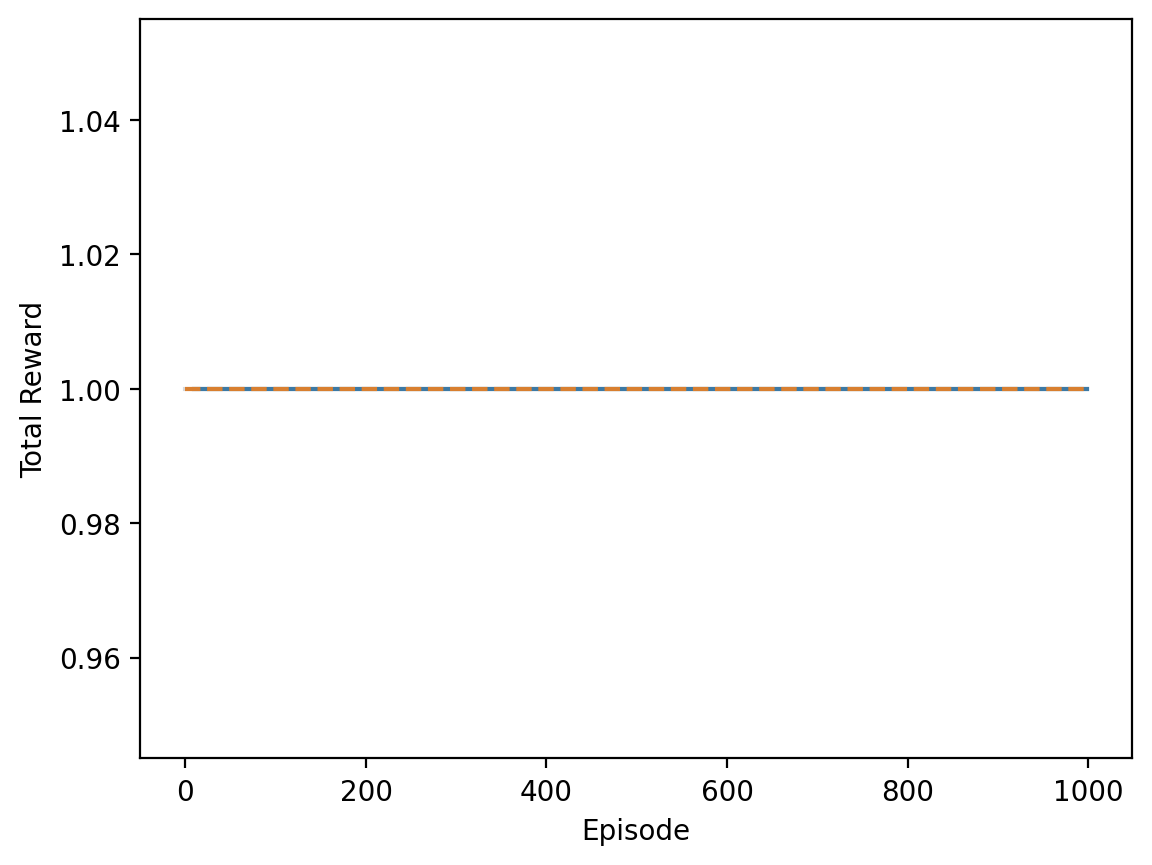

In [9]:
rewards = [run_episode(env, qtable=qtable).reward for _ in range(1000)]
print('Average reward: {}'.format(np.mean((rewards))))
plot_rewards(rewards);